# CNET 5442 — Sports Analytics Through Data and Networks (Spring 2026)

## Class 05 — Regression Pt 1.: Moneyball (Hakes & Sauer replication)



**Plan for today:** ~50 min slides → ~50 min code (this notebook)

**Paper:** Jahn K. Hakes & Raymond D. Sauer (2006), *An economic evaluation of the Moneyball hypothesis*, *Journal of Economic Perspectives*.

---

### What you should be able to do after this notebook

1. Treat regression as a **structured way to answer a question**, not a magic button.
2. Read a regression table: coefficient, standard error, p-value, $R^2$.
3. Reproduce the paper’s core logic using two regressions:
   - **Production:** what predicts winning? (Table 1 style)  
   - **Pricing:** what predicts salary? (Table 3 style)
4. Explain (and critique) the Moneyball claim as a **market mispricing + correction** story.

> **Working assumption:** you are technically strong, but you may not have seen the baseball stats or the econ framing before. We’ll build both.


## Homework 1, question 4

![](images/moneyball_screenshot.jpg)

In [1]:
# --- Imports and setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import zipfile

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 60)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

print("Ready.")


Ready.


In [2]:
DATA_DIR = 'data/'

## The core idea we’re testing

Moneyball claim (as framed by Hakes & Sauer):

> **OBP matters more than SLG for winning,** but the labor market **paid for SLG more than OBP** (at least pre-2004).  
> After *Moneyball* got popular, the market **corrected**.

So we do *two regressions*:

1. **Production regression:** Winning% ~ (OBP, SLG, and “against” versions)  
2. **Pricing regression:** log(Salary) ~ (OBP, SLG, and controls)

If those two regressions “disagree” (wins vs pay), that’s a mispricing story.


## Key metrics: OBP and SLG

We focus on two canonical hitting summaries.

### Slugging percentage (SLG)
Power-weighted total bases per at-bat:

$$
\mathrm{SLG} = \frac{1B + 2\cdot 2B + 3\cdot 3B + 4\cdot HR}{AB}
$$

where:

$$
1B = H - 2B - 3B - HR
$$

### On-base percentage (OBP)
How often a batter reaches base via hit, walk, or hit-by-pitch:

$$
\mathrm{OBP} = \frac{H + BB + HBP}{AB + BB + HBP + SF}
$$

A practical note: OBP and SLG are decimals (e.g., 0.320).  
A change like **+0.010 OBP** (“10 OBP points”) is meaningful.
________

## Regression, in the way we’ll use it today

A regression is a model for the **conditional average**:

$$
\mathbb{E}[Y \mid X] \approx \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p
$$

We’ll keep reminding ourselves of three translation rules:

1. **Coefficient** $\beta_k$: “holding other variables fixed, a 1-unit increase in $X_k$ changes the model’s *predicted* $Y$ by $\beta_k$.”
2. **Standard error (SE):** how uncertain we are about the coefficient estimate.
3. **$R^2$:** how much variation the model explains (not “truth”, not “causality”).

> We are doing **explanation + prediction-ish** modeling, not a clean causal design.


# Part A — Production: what predicts winning? (Table 1 logic)

We start at the team-season level (30 teams × 5 seasons = 150 rows in the paper).  
Our raw file is game-level, so we’ll aggregate up to team-season.

**We need:**
- team winning percentage
- team OBP and SLG (“for”)
- opponent OBP and SLG (“against”)

_______
Data: https://www.retrosheet.org/gamelogs/index.html

In [3]:
Teams = pd.read_excel(DATA_DIR + "Game logs 1999-2003.xlsx")
print(Teams.shape)
print(Teams.columns[:25])
Teams.head()

(12142, 161)
Index(['date', 'game_number', 'day', 'visitor', 'visitor_lg',
       'visitor_game_number', 'home', 'home_lg', 'home_game_number',
       'visitor_score', 'home_score', 'outs', 'daynight', 'completion',
       'forfeit', 'protest', 'park', 'attendance', 'game_minutes',
       'visitor_linescore', 'home_linescore', 'visitor_ab', 'visitor_h',
       'visitor_2b', 'visitor_3b'],
      dtype='object')


,date,game_number,day,visitor,visitor_lg,visitor_game_number,home,home_lg,home_game_number,visitor_score,home_score,outs,daynight,completion,forfeit,protest,park,attendance,game_minutes,visitor_linescore,home_linescore,visitor_ab,visitor_h,visitor_2b,visitor_3b,visitor_hr,visitor_rbi,visitor_sh,visitor_sf,visitor_hbp,visitor_bb,visitor_ibb,visitor_so,visitor_sb,visitor_cs,visitor_gidp,visitor_ci,visitor_lob,visitor_pitchers_used,visitor_individual_er,visitor_team_er,visitor_wp,visitor_balks,visitor_putouts,visitor_assists,visitor_errors,visitor_passed_balls,visitor_double_plays,visitor_triple_plays,home_ab,home_h,home_2b,home_3b,home_hr,home_rbi,home_sh,home_sf,home_hbp,home_bb,home_ibb,home_so,home_sb,home_cs,home_gidp,home_ci,home_lob,home_pitchers_used,home_individual_er,home_team_er,home_wp,home_balks,home_putouts,home_assists,home_errors,home_passed_balls,home_double_plays,home_triple_plays,hp_ump_id,hp_ump_name,1b_ump_id,1b_ump_name,2b_ump_id,2b_ump_name,3b_ump_id,3b_ump_name,lf_ump_id,lf_ump_name,rf_ump_id,rf_ump_name,visitor_manager_id,visitor_manager_name,home_manager_id,home_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,gwrbi_batter_id,gwrbi_batter_name,visitor_starting_pitcher_id,visitor_starting_pitcher_name,home_starting_pitcher_id,home_starting_pitcher_name,visitor_batter_1_id,visitor_batter_1_name,visitor_batter_1_pos,visitor_batter_2_id,visitor_batter_2_name,visitor_batter_2_pos,visitor_batter_3_id,visitor_batter_3_name,visitor_batter_3_pos,visitor_batter_4_id,visitor_batter_4_name,visitor_batter_4_pos,visitor_batter_5_id,visitor_batter_5_name,visitor_batter_5_pos,visitor_batter_6_id,visitor_batter_6_name,visitor_batter_6_pos,visitor_batter_7_id,visitor_batter_7_name,visitor_batter_7_pos,visitor_batter_8_id,visitor_batter_8_name,visitor_batter_8_pos,visitor_batter_9_id,visitor_batter_9_name,visitor_batter_9_pos,home_batter_1_id,home_batter_1_name,home_batter_1_pos,home_batter_2_id,home_batter_2_name,home_batter_2_pos,home_batter_3_id,home_batter_3_name,home_batter_3_pos,home_batter_4_id,home_batter_4_name,home_batter_4_pos,home_batter_5_id,home_batter_5_name,home_batter_5_pos,home_batter_6_id,home_batter_6_name,home_batter_6_pos,home_batter_7_id,home_batter_7_name,home_batter_7_pos,home_batter_8_id,home_batter_8_name,home_batter_8_pos,home_batter_9_id,home_batter_9_name,home_batter_9_pos,additional_info,acquisition
0,19990404,0,Sun,COL,NL,1,SDN,NL,1,8,2,54,N,NaN,NaN,NaN,MNT01,27104,190,150001001,100000100,42,18,1,0,1,8,1,0,0,2,0,6,2,0,1,0,10,4,2,2,0,0,27,9,0,0,1,0,32,6,1,0,0,2,0,0,0,6,0,8,1,0,1,0,9,5,8,8,0,0,27,10,0,0,2,0,ripps901,Steve Rippley,darlg901,Gary Darling,poncl901,Larry Poncino,mealj901,Jerry Meals,NaN,(none),NaN,(none),leylj801,Jim Leyland,bochb002,Bruce Bochy,kiled001,Darryl Kile,ashba002,Andy Ashby,NaN,(none),hamid001,Darryl Hamilton,kiled001,Darryl Kile,ashba002,Andy Ashby,hamid001,Darryl Hamilton,8,peren001,Neifi Perez,6,harrl001,Lenny Harris,9,bichd001,Dante Bichette,7,castv001,Vinny Castilla,5,heltt001,Todd Helton,3,lansm001,Mike Lansing,4,manwk001,Kirt Manwaring,2,kiled001,Darryl Kile,1,veraq001,Quilvio Veras,4,sandr002,Reggie Sanders,7,gwynt001,Tony Gwynn,9,joynw001,Wally Joyner,3,myerg001,Greg Myers,2,ariag001,George Arias,5,river002,Ruben Rivera,8,gomec001,Chris Gomez,6,ashba002,Andy Ashby,1,NaN,Y
1,19990405,0,Mon,TBA,AL,1,BAL,AL,1,7,10,51,D,NaN,NaN,NaN,BAL12,46733,225,101111002,00420004x,38,12,3,0,2,7,1,0,2,5,0,10,1,0,0,0,12,5,10,10,0,0,24,11,0,0,2,0,33,13,2,0,2,10,1,1,0,6,0,7,0,0,2,0,7,6,7,7,0,0,27,10,0,0,0,0,cobld901,Drew Coble,hendt901,Ted Hendry,mcclt901,Tim McClelland,cedeg901,Gary Cederstrom,NaN,(none),NaN,(none),rothl101,Larry Rothschild,millr801,Ray Miller,mussm001,Mike Mussina,alvaw001,Wilson Alvarez,timlm001,Mike Timlin,bellj002,Albert Belle,alvaw001,Wilson Alvarez,mussm001,Mike Mussina,winnr001,Randy Winn,8,martd002,Dave Martinez,9,cansj001,Jose Canseco,10,mcgrf001,Fred McGriff,3,flahj001,John Fl

## Step A1 — Wins, losses, ties; and the season year

Each row is one game. We'll create indicators for whether the home team won, the away team won, or it was a tie (rare).

In [28]:
Teams["hwin"] = np.where(Teams["home_score"] > Teams["visitor_score"], 1, 0)
Teams["awin"] = np.where(Teams["home_score"] < Teams["visitor_score"], 1, 0)
Teams["tie"]  = np.where(Teams["home_score"] == Teams["visitor_score"], 1, 0)

Teams["year"] = Teams["date"].astype(str).str[0:4].astype(int)

display(Teams[["date","year","home","visitor","home_score","visitor_score","hwin","awin","tie"]].head())
print("Ties in dataset:", int(Teams["tie"].sum()))


,date,year,home,visitor,home_score,visitor_score,hwin,awin,tie
0,19990404,1999,SDN,COL,2,8,0,1,0
1,19990405,1999,BAL,TBA,10,7,1,0,0
2,19990405,1999,KCA,BOS,3,5,0,1,0
3,19990405,1999,OAK,NYA,5,3,1,0,0
4,19990405,1999,SEA,CHA,2,8,0,1,0


Ties in dataset: 5


## Step A2 — Aggregate to team-season (for *and* against)

A game has two teams. We want *one row per team-season*, so we build:
- a “home-team contribution” table
- an “away-team contribution” table
and then combine.

Then we compute:

- **OBP**: (H + BB + HBP) / (AB + BB + HBP + SF)  
- **SLG**: total bases / AB

We do this twice:
- **FOR**: the team’s own offense
- **AGN** (“against”): what opposing batters did vs this team


In [29]:
# Columns needed to compute OBP and SLG
home_for_cols = ["home_ab","home_h","home_2b","home_3b","home_hr","home_sf","home_hbp","home_bb"]
vis_for_cols  = ["visitor_ab","visitor_h","visitor_2b","visitor_3b","visitor_hr","visitor_sf","visitor_hbp","visitor_bb"]

# When team is home, visitor_* is "against"
home_against_cols = vis_for_cols
# When team is visitor, home_* is "against"
vis_against_cols  = home_for_cols

# --- Aggregate games where team is HOME ---
Teamshome = (
    Teams
    .groupby(["home","year"], as_index=False)[
        home_for_cols + home_against_cols + ["hwin","awin"]
    ]
    .sum(numeric_only=True)
    .rename(columns={"home":"Team"})
)

display(Teamshome.head())

# --- Aggregate games where team is VISITOR ---
Teamsaway = (
    Teams
    .groupby(["visitor","year"], as_index=False)[
        vis_for_cols + vis_against_cols + ["hwin","awin"]
    ]
    .sum(numeric_only=True)
    .rename(columns={"visitor":"Team"})
)

display(Teamsaway.head())

# Merge to combine home + away season totals
Teams2 = pd.merge(Teamshome, Teamsaway, on=["Team","year"], how="inner", suffixes=("_home","_away"))
Teams2.shape


,Team,year,home_ab,home_h,home_2b,home_3b,home_hr,home_sf,home_hbp,home_bb,visitor_ab,visitor_h,visitor_2b,visitor_3b,visitor_hr,visitor_sf,visitor_hbp,visitor_bb,hwin,awin
0,ANA,1999,2666,669,118,13,74,21,23,267,2832,762,151,10,105,39,27,322,37,44
1,ANA,2000,2742,788,146,11,130,23,24,315,2867,800,144,8,113,24,15,320,46,35
2,ANA,2001,2736,731,122,12,86,29,30,251,2873,772,165,6,86,20,39,259,39,42
3,ANA,2002,2757,769,155,21,71,27,34,228,2799,685,132,5,70,29,22,260,54,27
4,ANA,2003,2685,717,135,17,68,22,27,226,2868,743,142,9,84,17,39,245,45,37


,Team,year,visitor_ab,visitor_h,visitor_2b,visitor_3b,visitor_hr,visitor_sf,visitor_hbp,visitor_bb,home_ab,home_h,home_2b,home_3b,home_hr,home_sf,home_hbp,home_bb,hwin,awin
0,ANA,1999,2828,735,130,9,84,21,20,244,2645,710,134,15,72,26,29,302,48,33
1,ANA,2000,2886,786,163,23,106,20,23,293,2742,734,132,15,115,29,21,342,45,36
2,ANA,2001,2815,716,153,14,72,24,47,243,2656,680,120,13,82,19,25,266,45,36
3,ANA,2002,2921,834,178,11,81,37,40,234,2654,660,116,14,99,30,27,249,36,45
4,ANA,2003,2802,756,141,16,82,28,29,250,2664,701,118,18,106,25,37,241,48,32


(150, 38)

In [30]:
# Wins = home wins (when home) + away wins (when visitor)
Teams2["wins"] = Teams2["hwin_home"] + Teams2["awin_away"]

# --- OBP FOR ---
Teams2["OBPFOR"] = (
    (Teams2["home_h_home"] + Teams2["visitor_h_away"] +
     Teams2["home_bb_home"] + Teams2["visitor_bb_away"] +
     Teams2["home_hbp_home"] + Teams2["visitor_hbp_away"])
    /
    (Teams2["home_ab_home"] + Teams2["visitor_ab_away"] +
     Teams2["home_bb_home"] + Teams2["visitor_bb_away"] +
     Teams2["home_hbp_home"] + Teams2["visitor_hbp_away"] +
     Teams2["home_sf_home"] + Teams2["visitor_sf_away"])
)

# --- OBP AGAINST ---
Teams2["OBPAGN"] = (
    (Teams2["home_h_away"] + Teams2["visitor_h_home"] +
     Teams2["home_bb_away"] + Teams2["visitor_bb_home"] +
     Teams2["home_hbp_away"] + Teams2["visitor_hbp_home"])
    /
    (Teams2["home_ab_away"] + Teams2["visitor_ab_home"] +
     Teams2["home_bb_away"] + Teams2["visitor_bb_home"] +
     Teams2["home_hbp_away"] + Teams2["visitor_hbp_home"] +
     Teams2["home_sf_away"] + Teams2["visitor_sf_home"])
)

# --- SLG FOR ---
Teams2["SLGFOR"] = (
    (
        (Teams2["home_h_home"] + Teams2["visitor_h_away"])
        - (Teams2["home_2b_home"] + Teams2["visitor_2b_away"])
        - (Teams2["home_3b_home"] + Teams2["visitor_3b_away"])
        - (Teams2["home_hr_home"] + Teams2["visitor_hr_away"])
        + 2*(Teams2["home_2b_home"] + Teams2["visitor_2b_away"])
        + 3*(Teams2["home_3b_home"] + Teams2["visitor_3b_away"])
        + 4*(Teams2["home_hr_home"] + Teams2["visitor_hr_away"])
    )
    /
    (Teams2["home_ab_home"] + Teams2["visitor_ab_away"])
)

# --- SLG AGAINST ---
Teams2["SLGAGN"] = (
    (
        (Teams2["home_h_away"] + Teams2["visitor_h_home"])
        - (Teams2["home_2b_away"] + Teams2["visitor_2b_home"])
        - (Teams2["home_3b_away"] + Teams2["visitor_3b_home"])
        - (Teams2["home_hr_away"] + Teams2["visitor_hr_home"])
        + 2*(Teams2["home_2b_away"] + Teams2["visitor_2b_home"])
        + 3*(Teams2["home_3b_away"] + Teams2["visitor_3b_home"])
        + 4*(Teams2["home_hr_away"] + Teams2["visitor_hr_home"])
    )
    /
    (Teams2["home_ab_away"] + Teams2["visitor_ab_home"])
)

Teams3 = Teams2[["year","Team","wins","OBPFOR","OBPAGN","SLGFOR","SLGAGN"]].copy()
display(Teams3.head())


,year,Team,wins,OBPFOR,OBPAGN,SLGFOR,SLGAGN
0,1999,ANA,70,0.321511,0.345869,0.394976,0.426876
1,2000,ANA,82,0.352355,0.350943,0.472459,0.452844
2,2001,ANA,75,0.326802,0.331493,0.404972,0.412190
3,2002,ANA,99,0.340714,0.313509,0.432547,0.392078
4,2003,ANA,77,0.330367,0.326923,0.412794,0.420824


## Step A3 — Winning percentage (Win% = wins / games)

Sanity check: we should get **150 team-seasons** for 1999–2003.

In [31]:
TeamsGh = Teams.groupby(["year","home"], as_index=False)["hwin"].count().rename(columns={"home":"Team","hwin":"home_games"})
TeamsGa = Teams.groupby(["year","visitor"], as_index=False)["awin"].count().rename(columns={"visitor":"Team","awin":"away_games"})

TeamsG = pd.merge(TeamsGh, TeamsGa, on=["Team","year"], how="inner")
TeamsG["Games"] = TeamsG["home_games"] + TeamsG["away_games"]

Teams3 = pd.merge(Teams3, TeamsG[["Team","year","Games"]], on=["Team","year"], how="inner")
Teams3["wpc"] = Teams3["wins"] / Teams3["Games"]

display(Teams3.head())
print("Rows (team-seasons):", Teams3.shape[0])


,year,Team,wins,OBPFOR,OBPAGN,SLGFOR,SLGAGN,Games,wpc
0,1999,ANA,70,0.321511,0.345869,0.394976,0.426876,162,0.432099
1,2000,ANA,82,0.352355,0.350943,0.472459,0.452844,162,0.506173
2,2001,ANA,75,0.326802,0.331493,0.404972,0.412190,162,0.462963
3,2002,ANA,99,0.340714,0.313509,0.432547,0.392078,162,0.611111
4,2003,ANA,77,0.330367,0.326923,0.412794,0.420824,162,0.475309


Rows (team-seasons): 150


## Step A4 — Quick sanity checks (always do these)

Before we regress anything, we check:
- Are OBP and SLG in reasonable ranges?
- Are “for” and “against” roughly symmetric (league-wide)?
- Does better OBP *look* related to winning?

,count,mean,std,min,25%,50%,75%,max
year,150.0,2001.000000,1.418951,1999.000000,2000.000000,2001.000000,2002.000000,2003.000000
wpc,150.0,0.499774,0.078002,0.265432,0.438272,0.503086,0.564345,0.716049
OBPFOR,150.0,0.336895,0.014206,0.300000,0.326146,0.336961,0.346534,0.373442
SLGFOR,150.0,0.427071,0.025683,0.368267,0.409374,0.426016,0.446017,0.490900
OBPAGN,150.0,0.336875,0.015691,0.300511,0.325606,0.338911,0.347871,0.384331
SLGAGN,150.0,0.427018,0.027940,0.353754,0.406782,0.426855,0.449155,0.499115


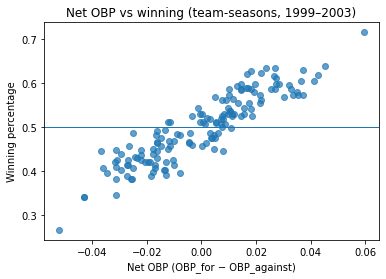

In [32]:
display(Teams3[["year","Team","wpc","OBPFOR","SLGFOR","OBPAGN","SLGAGN"]].describe().T)

plt.figure(figsize=(6,4))
plt.scatter(Teams3["OBPFOR"]-Teams3["OBPAGN"], Teams3["wpc"], alpha=0.7)
plt.xlabel("Net OBP (OBP_for − OBP_against)")
plt.ylabel("Winning percentage")
plt.title("Net OBP vs winning (team-seasons, 1999–2003)")
plt.axhline(0.5, linewidth=1)
plt.show()


## Step A5 — The four regressions (Table 1 style)

Hakes & Sauer run four models:

1. **OBP only** (for + against)  
2. **SLG only** (for + against)  
3. **OBP + SLG**  
4. **Restricted version** where “for” and “against” coefficients are constrained to be the same magnitude  
   - implemented by using *differences*: (OBP_for − OBP_against) and (SLG_for − SLG_against)

> **Pause (student check):**  
> Which do you think will matter more for winning, OBP or SLG? Why?


In [33]:
WinOBP_lm = smf.ols("wpc ~ OBPFOR + OBPAGN", data=Teams3).fit()
WinSLG_lm = smf.ols("wpc ~ SLGFOR + SLGAGN", data=Teams3).fit()
WinOBPSLG_lm = smf.ols("wpc ~ OBPFOR + OBPAGN + SLGFOR + SLGAGN", data=Teams3).fit()
WinOBPSLGR_lm = smf.ols("wpc ~ I(OBPFOR - OBPAGN) + I(SLGFOR - SLGAGN)", data=Teams3).fit()

# Quick look at one regression:
WinOBPSLG_lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wpc   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     279.0
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           5.15e-67
Time:                        09:43:40   Log-Likelihood:                 332.53
No. Observations:                 150   AIC:                            -655.1
Df Residuals:                     145   BIC:                            -640.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5052      0.073      6.930      0.000       0.361       0.649
OBPFOR         2.1215      0.255      8.331      0.000       1.618       2.625
OBPAGN        -1.9156      0.256     -7.489      0.000      -2.421      -1.410
SLGFOR         0.8143      0.141      5.775      0.000       0.536       1.093
SLGAGN        -0.9897      0.144     -6.868      0.000      -1.275      -0.705
==============================================================================
Omnibus:                        1.334   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                1.426
Skew:                          -0.196   Prob(JB):                        0.490
Kurtosis:                       2.727   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Presenting results in a Table 1-ish format

We’ll use `summary_col` to put regressions side-by-side (similar to the paper).

In [34]:
Header = ["(1) OBP", "(2) SLG", "(3) OBP+SLG", "(4) Restricted"]

Table_1 = summary_col(
    [WinOBP_lm, WinSLG_lm, WinOBPSLG_lm, WinOBPSLGR_lm],
    regressor_order=[
        "OBPFOR","OBPAGN",
        "SLGFOR","SLGAGN",
        "I(OBPFOR - OBPAGN)","I(SLGFOR - SLGAGN)",
        "Intercept"
    ],
    stars=True,
    model_names=Header,
    info_dict={"N": lambda x: f"{int(x.nobs)}", "R2": lambda x: f"{x.rsquared:.3f}"},
)
print(Table_1)



                    (1) OBP    (2) SLG   (3) OBP+SLG (4) Restricted
-------------------------------------------------------------------
OBPFOR             3.3009***             2.1215***                 
                   (0.1891)              (0.2546)                  
OBPAGN             -3.3105***            -1.9156***                
                   (0.1712)              (0.2558)                  
SLGFOR                        1.7552***  0.8143***                 
                              (0.1160)   (0.1410)                  
SLGAGN                        -1.9676*** -0.9897***                
                              (0.1066)   (0.1441)                  
I(OBPFOR - OBPAGN)                                   2.0327***     
                                                     (0.1796)      
I(SLGFOR - SLGAGN)                                   0.8992***     
                                                     (0.1043)      
Intercept          0.5030***  0.5904***  0.5052

## Step A6 — Interpreting a coefficient in baseball units (wins)

Suppose the restricted model gives a coefficient $\beta_{OBP}$ on:

$$
(OBP_{for} - OBP_{against})
$$

Then a change of **10 OBP “points”** (0.010) changes predicted win% by:

$$
\Delta Win\% \approx \beta_{OBP} \times 0.010
$$

And in a 162-game season:

$$
\Delta Wins \approx 162 \times \Delta Win\%
$$

We’ll compute this using *your fitted coefficient*.


In [74]:
beta_obp_for = WinOBPSLGR_lm.params["I(OBPFOR - OBPAGN)"]
delta_wpct = beta_obp_for * 0.010
delta_wins_162 = 162 * delta_wpct

beta_obp_for, delta_wpct, delta_wins_162


(2.0326830428391136, 0.020326830428391136, 3.292946529399364)

## Step A7 — Small predictive check (not a full ML workflow)

We’ll do a simple time split:
- train on 1999–2001
- test on 2002–2003

This is just to reinforce the idea that regression is a *model* we can use to predict, not just a table-making machine.


In [75]:
train = Teams3[Teams3["year"] <= 2001].copy()
test  = Teams3[Teams3["year"] >= 2002].copy()

model = smf.ols("wpc ~ OBPFOR + OBPAGN + SLGFOR + SLGAGN", data=train).fit()
test["pred_wpc"] = model.predict(test)

baseline = np.repeat(train["wpc"].mean(), len(test))

print("Test RMSE (model):   ", rmse(test["wpc"], test["pred_wpc"]))
print("Test RMSE (baseline):", rmse(test["wpc"], baseline))
print("Test MAE (model):    ", mean_absolute_error(test["wpc"], test["pred_wpc"]))
print("Test MAE (baseline): ", mean_absolute_error(test["wpc"], baseline))


Test RMSE (model):    0.02944220316521204
Test RMSE (baseline): 0.08549842731338422
Test MAE (model):     0.024019595625545422
Test MAE (baseline):  0.0713926015518045


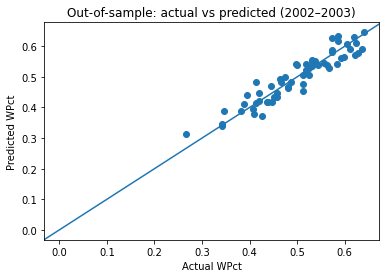

In [76]:
plt.figure()
plt.scatter(test["wpc"], test["pred_wpc"])
plt.xlabel("Actual WPct")
plt.ylabel("Predicted WPct")
plt.title("Out-of-sample: actual vs predicted (2002–2003)")
plt.axline((0,0), slope=1)
plt.show()


# Part B — Pricing: do salaries reward the stats that win? (Table 3 logic)

Now we shift from **teams** to **players**.

**Outcome:** `ln(Salary)` in year *t*  
**Predictors:** OBP, SLG, PA in year *t-1* (plus controls)

Why log salary?
- A coefficient is roughly a **percent change** for a 1-unit change in the predictor (good for interpretation).


## Step B1 — Load salaries and create the “salary master”

We’ll start with salary rows and then merge in:
- batting performance (from the prior year)
- a crude “experience” proxy (years since debut)
- primary defensive position (catcher / infielder indicators)

This follows the spirit of the paper, even if our exact data sources may differ.


In [77]:
Salary = pd.read_csv(DATA_DIR + "Salaries.csv")
display(Salary.head())
print("Rows:", Salary.shape[0])

Salary = Salary[Salary["salary"] > 0].copy()
Salary["lnSal"] = np.log(Salary["salary"])

Salary = Salary.rename(columns={"yearID":"SalYear"})
display(Salary.head())
print("Rows after salary>0:", Salary.shape[0])

Master = Salary.copy()


,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


Rows: 26428


,SalYear,teamID,lgID,playerID,salary,lnSal
0,1985,ATL,NL,barkele01,870000,13.676248
1,1985,ATL,NL,bedrost01,550000,13.217674
2,1985,ATL,NL,benedbr01,545000,13.208541
3,1985,ATL,NL,campri01,633333,13.358752
4,1985,ATL,NL,ceronri01,625000,13.345507


Rows after salary>0: 26426


In [78]:
Batting = pd.read_csv(DATA_DIR + "Batting.csv")
display(Batting.head())
print("Rows:", Batting.shape[0])

# Sum across stints: one row per player-season
Batting = Batting.groupby(["playerID","yearID"], as_index=False).sum(numeric_only=True)

# Restrict to modern-ish era + playing time
Batting = Batting[(Batting["yearID"] >= 1993) & (Batting["yearID"] <= 2016) & (Batting["AB"] >= 130)].copy()
print("Rows after filters:", Batting.shape[0])
display(Batting.head())

# Plate appearances (PA)
Batting["PA"] = Batting["AB"] + Batting["BB"] + Batting["HBP"] + Batting["SH"] + Batting["SF"]

# OBP
Batting["OBP"] = (Batting["H"] + Batting["BB"] + Batting["HBP"]) / (Batting["AB"] + Batting["BB"] + Batting["HBP"] + Batting["SF"])

# SLG (using Doubles / Triples column names in this dataset)
Batting["SLG"] = (
    (Batting["H"] - Batting["Doubles"] - Batting["Triples"] - Batting["HR"])
    + 2*Batting["Doubles"] + 3*Batting["Triples"] + 4*Batting["HR"]
) / Batting["AB"]

# Lag performance into next year's salary
Batting["SalYear"] = Batting["yearID"] + 1

display(Batting[["playerID","yearID","SalYear","AB","PA","OBP","SLG"]].head())


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,Doubles,Triples,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,0,0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,0,0,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,5,0,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,2,2,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,3,0,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,NaN


Rows: 102816
Rows after filters: 9303


,playerID,yearID,stint,G,AB,R,H,Doubles,Triples,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
98,abbotje01,1998,1,89,244,33,68,14,1,12,41.0,3.0,3.0,9,28.0,1.0,0.0,2.0,5.0,2.0
100,abbotje01,2000,1,80,215,31,59,15,1,3,29.0,2.0,1.0,21,38.0,1.0,2.0,2.0,1.0,2.0
113,abbotku01,1994,1,101,345,41,86,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0
114,abbotku01,1995,1,120,420,60,107,18,7,17,60.0,4.0,3.0,36,110.0,4.0,5.0,2.0,5.0,6.0
115,abbotku01,1996,1,109,320,37,81,18,7,8,33.0,3.0,3.0,22,99.0,1.0,3.0,4.0,0.0,7.0


,playerID,yearID,SalYear,AB,PA,OBP,SLG
98,abbotje01,1998,1999,244,260.0,0.298450,0.491803
100,abbotje01,2000,2001,215,241.0,0.343096,0.395349
113,abbotku01,1994,1995,345,371.0,0.290761,0.394203
114,abbotku01,1995,1996,420,468.0,0.317597,0.452381
115,abbotku01,1996,1997,320,349.0,0.307246,0.428125


### Merge batting performance into salary master

After this merge, each row corresponds to a **player × salary year**, with predictors from the previous season.

In [79]:
Master = pd.merge(Batting, Master, on=["playerID","SalYear"], how="inner")
print("Master rows after merge:", Master.shape[0])
display(Master.head())


Master rows after merge: 7784


,playerID,yearID,stint,G,AB,R,H,Doubles,Triples,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,PA,OBP,SLG,SalYear,teamID,lgID,salary,lnSal
0,abbotje01,1998,1,89,244,33,68,14,1,12,41.0,3.0,3.0,9,28.0,1.0,0.0,2.0,5.0,2.0,260.0,0.298450,0.491803,1999,CHA,AL,255000,12.449019
1,abbotje01,2000,1,80,215,31,59,15,1,3,29.0,2.0,1.0,21,38.0,1.0,2.0,2.0,1.0,2.0,241.0,0.343096,0.395349,2001,FLO,NL,300000,12.611538
2,abbotku01,1994,1,101,345,41,86,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0,371.0,0.290761,0.394203,1995,FLO,NL,119000,11.686879
3,abbotku01,1995,1,120,420,60,107,18,7,17,60.0,4.0,3.0,36,110.0,4.0,5.0,2.0,5.0,6.0,468.0,0.317597,0.452381,1996,FLO,NL,250000,12.429216
4,abbotku01,1996,1,109,320,37,81,18,7,8,33.0,3.0,3.0,22,99.0,1.0,3.0,4.0,0.0,7.0,349.0,0.307246,0.428125,1997,FLO,NL,650000,13.384728


## Step B2 — Bargaining status (proxy)

The paper uses bargaining categories (pre-arb, arb, free agency).  
We approximate this with **experience since debut**:

- `Arb = 1` if 3 ≤ experience ≤ 6  
- `Free = 1` if experience > 6  

This is not perfect, but it gets the core control structure in place.


In [80]:
People = pd.read_csv(DATA_DIR + "People.csv")
Debut = People[["playerID","debut"]].copy()

# Extract debut year from date string like '1998-04-15'
Debut["debutyr"] = pd.to_numeric(Debut["debut"].astype(str).str[0:4], errors="coerce")

# Merge into Master
Master = pd.merge(Master, Debut[["playerID","debutyr"]], on="playerID", how="left")

# Experience in performance year
Master["Exp"] = Master["yearID"] - Master["debutyr"]

Master["Arb"] = np.where((Master["Exp"] >= 3) & (Master["Exp"] <= 6), 1, 0)
Master["Free"] = np.where(Master["Exp"] > 6, 1, 0)

display(Master[["playerID","yearID","SalYear","debutyr","Exp","Arb","Free"]].head())


,playerID,yearID,SalYear,debutyr,Exp,Arb,Free
0,abbotje01,1998,1999,1997.0,1.0,0,0
1,abbotje01,2000,2001,1997.0,3.0,1,0
2,abbotku01,1994,1995,1993.0,1.0,0,0
3,abbotku01,1995,1996,1993.0,2.0,0,0
4,abbotku01,1996,1997,1993.0,3.0,1,0


## Step B3 — Position controls (catcher + infielder)

Defensive value differs by position. The paper adds controls for:
- catcher
- infield (2B/3B/SS)

We’ll derive a primary position from games played at each position (Appearances table).


In [81]:
Appearances = pd.read_csv(DATA_DIR + "Appearances.csv")

# Aggregate across stints
Appearances = Appearances.groupby(["playerID","yearID"], as_index=False).sum(numeric_only=True)

# Compute max games among key positions
pos_cols = ["G_c","G_1b","G_2b","G_3b","G_ss","G_of","G_dh"]
Appearances["Max_G"] = Appearances[pos_cols].max(axis=1)

# Drop seasons with no fielding position recorded (often DH-only or missing)
Appearances = Appearances[Appearances["Max_G"] > 0].copy()

def primary_pos(row):
    if row["Max_G"] == row["G_c"]: return "C"
    if row["Max_G"] == row["G_1b"]: return "1B"
    if row["Max_G"] == row["G_2b"]: return "2B"
    if row["Max_G"] == row["G_3b"]: return "3B"
    if row["Max_G"] == row["G_ss"]: return "SS"
    if row["Max_G"] == row["G_of"]: return "OF"
    if row["Max_G"] == row["G_dh"]: return "DH"
    return np.nan

Appearances["POS"] = Appearances.apply(primary_pos, axis=1)

Appearances["Catch"] = np.where(Appearances["POS"] == "C", 1, 0)
Appearances["Infld"] = np.where(Appearances["POS"].isin(["2B","3B","SS"]), 1, 0)

Appearances_small = Appearances[["playerID","yearID","POS","Catch","Infld"]].copy()

# Merge into Master
Master = pd.merge(Master, Appearances_small, on=["playerID","yearID"], how="left")

# Fill missing position controls with 0 (conservative default)
Master["Catch"] = Master["Catch"].fillna(0).astype(int)
Master["Infld"] = Master["Infld"].fillna(0).astype(int)

display(Master[["playerID","yearID","POS","Catch","Infld"]].head())
print("Master columns:", Master.columns.tolist())


,playerID,yearID,POS,Catch,Infld
0,abbotje01,1998,OF,0,0
1,abbotje01,2000,OF,0,0
2,abbotku01,1994,SS,0,1
3,abbotku01,1995,SS,0,1
4,abbotku01,1996,SS,0,1


Master columns: ['playerID', 'yearID', 'stint', 'G', 'AB', 'R', 'H', 'Doubles', 'Triples', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'PA', 'OBP', 'SLG', 'SalYear', 'teamID', 'lgID', 'salary', 'lnSal', 'debutyr', 'Exp', 'Arb', 'Free', 'POS', 'Catch', 'Infld']


### (Optional) Save the merged master table

Useful if you want to avoid rebuilding it each time.

In [85]:
# Uncomment if you want to save a copy where you're running the notebook
# Master.to_csv(DATA_DIR + "Master_built.csv", index=False)
# print("Saved:", DATA_DIR + "Master_built.csv")


## Step B4 — Replicating Table 3 (2000–2004)

We’ll focus on the exact window in Hakes & Sauer:

- salary years 2000–2004 (predictors from 1999–2003)

We run:
- a pooled regression (all years)
- then year-by-year regressions (key for the “market corrected” story)

> **Student check:**  
> Pre-2004, do you expect OBP’s coefficient in the salary regression to be small? Why?


In [86]:
MB_Data = Master[(Master["SalYear"] >= 2000) & (Master["SalYear"] <= 2004)].copy()
MB_Data_Pre = Master[(Master["SalYear"] >= 2000) & (Master["SalYear"] <= 2003)].copy()

formula = "lnSal ~ OBP + SLG + PA + Arb + Free + Catch + Infld"

Val_All_lm = smf.ols(formula=formula, data=MB_Data).fit()
Val_Pre_lm = smf.ols(formula=formula, data=MB_Data_Pre).fit()

# Year-by-year
Val_year = {}
for y in [2000,2001,2002,2003,2004]:
    Val_year[y] = smf.ols(formula=formula, data=Master[Master["SalYear"] == y]).fit()

Val_All_lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnSal   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     485.7
Date:                Sun, 01 Feb 2026   Prob (F-statistic):               0.00
Time:                        10:05:49   Log-Likelihood:                -1928.6
No. Observations:                1741   AIC:                             3873.
Df Residuals:                    1733   BIC:                             3917.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1090      0.164     61.773      0.000       9.788      10.430
OBP            1.4783      0.628      2.355      0.019       0.247       2.709
SLG            2.3884      0.316      7.553      0.000       1.768       3.009
PA             0.0031      0.000     25.962      0.000       0.003       0.003
Arb            1.2076      0.049     24.585      0.000       1.111       1.304
Free           1.8050      0.049     37.033      0.000       1.709       1.901
Catch          0.1115      0.057      1.972      0.049       0.001       0.222
Infld         -0.0502      0.041     -1.231      0.219      -0.130       0.030
==============================================================================
Omnibus:                        5.756   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                6.893
Skew:                           0.026   Prob(JB):                       0.0319
Kurtosis:                       3.304   Cond. No.                     1.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpreting log-salary coefficients (quick rule of thumb)

If the model is:

$$
\ln(\text{Salary}) = \beta_0 + \beta_1 \cdot OBP + \cdots
$$

Then a change in OBP of $\Delta$ implies an approximate percent change in salary of:

$$
100 \times \beta_1 \Delta \%
$$

We’ll use this carefully: OBP changes are small (e.g., 0.010 is 10 “points”).


In [87]:
# Example: interpret a 0.010 OBP change using the pooled Moneyball-window model
# (Your coefficient names may differ depending on your exact formula.)

# We'll pull the pooled model from the code above if it exists.
# If you re-ran things and renamed objects, adjust this cell accordingly.

try:
    b_obp = Val_All_lm.params["OBP"]
    print("Pooled OBP coef:", b_obp)
    print("Approx % salary change for +0.010 OBP:", 100*b_obp*0.010)
except Exception as e:
    print("Couldn't find Val_All_lm or OBP coefficient yet. That's fine—run the regressions above first.")
    print("Error:", e)


Pooled OBP coef: 1.4783281750556645
Approx % salary change for +0.010 OBP: 1.4783281750556645


## Step B5 — Make a clean “Table 3”-style coefficient table

We extract the OBP and SLG coefficients (and SEs) across 2000–2004.

In [88]:
Header = ["All years","2000–2003","2000","2001","2002","2003","2004"]

Table_3 = summary_col(
    [Val_All_lm, Val_Pre_lm, Val_year[2000], Val_year[2001], Val_year[2002], Val_year[2003], Val_year[2004]],
    regressor_order=["OBP","SLG","PA","Arb","Free","Catch","Infld","Intercept"],
    stars=True,
    model_names=Header,
    info_dict={"N": lambda x: f"{int(x.nobs)}", "R2": lambda x: f"{x.rsquared:.3f}"},
)
print(Table_3)



               All years  2000–2003     2000      2001       2002       2003       2004  
-----------------------------------------------------------------------------------------
OBP            1.4783**   0.7958     2.1792*   0.1319     0.5952     1.8903     4.3528***
               (0.6277)   (0.6768)   (1.2168)  (1.2093)   (1.5658)   (1.5849)   (1.6303) 
SLG            2.3884***  2.4908***  2.5501*** 3.2241***  2.3124***  1.9447**   2.1707***
               (0.3162)   (0.3402)   (0.6100)  (0.5971)   (0.7241)   (0.8462)   (0.8203) 
PA             0.0031***  0.0031***  0.0023*** 0.0032***  0.0033***  0.0034***  0.0029***
               (0.0001)   (0.0001)   (0.0002)  (0.0002)   (0.0003)   (0.0003)   (0.0003) 
Arb            1.2076***  1.2559***  1.2960*** 1.1107***  1.2889***  1.2466***  1.0442***
               (0.0491)   (0.0536)   (0.1016)  (0.1000)   (0.1143)   (0.1139)   (0.1198) 
Free           1.8050***  1.8729***  1.9140*** 1.7884***  1.9372***  1.8138***  1.5602***
         

### Plot the OBP and SLG coefficients over time (key Moneyball visual)

,SalYear,var,coef,se
0,2000,OBP,2.179200,1.216804
1,2000,SLG,2.550102,0.610028
2,2001,OBP,0.131946,1.209322
3,2001,SLG,3.224087,0.597077
4,2002,OBP,0.595161,1.565801
5,2002,SLG,2.312353,0.724141
6,2003,OBP,1.890323,1.584903
7,2003,SLG,1.944713,0.846184
8,2004,OBP,4.352840,1.630254
9,2004,SLG,2.170674,0.820265


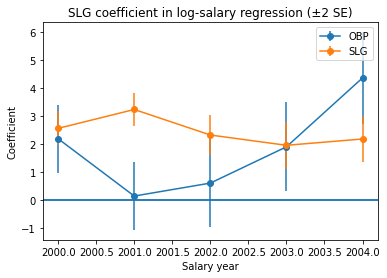

In [89]:
rows=[]
for y in [2000,2001,2002,2003,2004]:
    res = Val_year[y]
    for var in ["OBP","SLG"]:
        rows.append({
            "SalYear": y,
            "var": var,
            "coef": res.params.get(var, np.nan),
            "se": res.bse.get(var, np.nan),
        })
coef_df = pd.DataFrame(rows)

display(coef_df)

plt.figure()
for var in ["OBP","SLG"]:
    sub = coef_df[coef_df["var"]==var].sort_values("SalYear")
    plt.errorbar(sub["SalYear"], sub["coef"], yerr=sub["se"], fmt="o-", label=var)
    plt.axhline(0)
    plt.legend()
    plt.title(f"{var} coefficient in log-salary regression (±2 SE)")
    plt.xlabel("Salary year")
    plt.ylabel("Coefficient")

plt.show()


# Part C — Synthesis: mispricing + correction

At this point you should be able to say (in plain English):

1. **Production side:** OBP matters a lot for winning (Table 1 logic in Hakes & Sauer 2006).
2. **Pricing side:** pre-2004, OBP is not rewarded in salary the way SLG is (Table 3 logic).
3. **Correction:** in 2004, OBP’s salary coefficient jumps (market adjustment).

Now we’ll do two quick “wrap” steps:
- compare directions/magnitudes side-by-side
- then talk about what this does **not** prove (limits)


In [90]:
# A quick side-by-side comparison using *your* estimated models

print("=== Production (winning) — restricted model ===")
print(WinOBPSLGR_lm.summary().tables[1])

print("\n=== Pricing (salary) — pooled 2000–2003 model (if created) ===")
try:
    print(Val_Pre_lm.summary().tables[1])
except Exception as e:
    print("Val_Pre_lm not found; run the Table 3 regressions cell above.")


=== Production (winning) — restricted model ===
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4997      0.002    229.103      0.000       0.495       0.504
I(OBPFOR - OBPAGN)     2.0327      0.180     11.318      0.000       1.678       2.388
I(SLGFOR - SLGAGN)     0.8992      0.104      8.618      0.000       0.693       1.105

=== Pricing (salary) — pooled 2000–2003 model (if created) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2248      0.176     58.008      0.000       9.879      10.571
OBP            0.7958      0.677      1.176      0.240      -0.532       2.123
SLG            2.4908      0.340      7.322      0.000       1.823       3.158
PA             0.0031      0.000     24.172      0.000    

## Limits / critique (what not to over-claim)

Be careful about these common pitfalls:

- **Regression ≠ causality**: OBP is correlated with winning, but this setup is not a clean causal design.
- **Omitted variables**: defense, baserunning, park effects, injuries, etc.
- **Measurement / selection**: we filter to players with enough AB; long contracts create inertia.
- **Timeline caution**: *Moneyball* is 2003; the paper’s big salary shift shows up in 2004. Suggestive, not airtight.

The paper is pretty careful about interpretation — we should be too.


__________
## Next time...
Regression Pt. 2 — Expectation & Likelihood `class_06_regression_02_expectation_likelihood.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Github: https://github.com/jkbren/cnet5442_sp26
    - Syllabus and course details: https://brennanklein.com/cnet5442-spring26
2. Hakes, Jahn K., & Sauer, Raymond D. (2006). *An Economic Evaluation of the Moneyball Hypothesis.* **Journal of Economic Perspectives**, 20(3), 173–185.
3. Lewis, Michael (2003). *Moneyball: The Art of Winning an Unfair Game.* W. W. Norton.
4. Retrosheet game logs (team-game data; used by Hakes & Sauer for Table 1): http://www.retrosheet.org
5. Lahman Baseball Database / Baseball Databank (player performance + salaries tables used in many replications): https://sabr.org/lahman-database/
6. Hastie, Tibshirani, & Friedman. *The Elements of Statistical Learning* (conceptual + applied).
